# Import libraries and data

In [4]:
# Import libs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# Connect to PostgreSQL server
import os
from dotenv import load_dotenv
load_dotenv()
from pangres import upsert
from sqlalchemy import text, create_engine

# db info
db_username = os.environ.get('db_username')
db_password = os.environ.get('db_password')
db_host = os.environ.get('db_host')
db_port = os.environ.get('db_port')
db_name = os.environ.get('db_name')

def create_db_connection_string(db_username, db_password, db_host, db_port, db_name):
    connection_url = 'postgresql+psycopg2://' + db_username + ':' + db_password + '@' + db_host + ':' + db_port + '/' + db_name
    return connection_url

conn = create_db_connection_string(db_username, db_password, db_host, db_port, db_name)

db_engine = create_engine(conn, pool_recycle = 3600)

# Create DataFrame
with db_engine.connect() as connection:
    df = pd.read_sql(text('select * from soloq.matchesv2'), connection)


# Data Cleaning

In [2]:
# Dropping remade games
df = df[df['gameEndedInEarlySurrender'] == False]

# Dropping duplicate games -> impossible two people to have exact game stats
df.drop_duplicates()

# Check for null values
df.isna().sum()

uuid                         0
totalHealsOnTeammates        0
largestCriticalStrike        0
damageSelfMitigated          0
bountyLevel                  0
                            ..
totalTimeSpentDead           0
gameEndedInEarlySurrender    0
gameEndedInSurrender         0
teamEarlySurrendered         0
win                          0
Length: 96, dtype: int64

# Preliminary Data Exploration

Main goals of this:
Distributions of quantitative features
Possible values for qualitative

In [3]:
df.columns

Index(['uuid', 'totalHealsOnTeammates', 'largestCriticalStrike',
       'damageSelfMitigated', 'bountyLevel', 'consumablesPurchased',
       'spell1Casts', 'spell2Casts', 'spell3Casts', 'spell4Casts',
       'summoner1Casts', 'summoner1Id', 'summoner2Casts', 'summoner2Id',
       'matchId', 'teamId', 'gameDuration', 'gameVersion', 'summonerName',
       'puuid', 'lane', 'role', 'summonerLevel', 'teamPosition',
       'champExperience', 'champLevel', 'championName', 'kills', 'deaths',
       'assists', 'doubleKills', 'tripleKills', 'quadraKills', 'pentaKills',
       'largestKillingSpree', 'largestMultiKill', 'killingSprees',
       'firstBloodAssist', 'firstBloodKill', 'unrealKills', 'totalDamageDealt',
       'totalDamageDealtToChampions', 'totalDamageShieldedOnTeammates',
       'totalDamageTaken', 'totalHeal', 'trueDamageDealt',
       'trueDamageDealtToChampions', 'trueDamageTaken', 'magicDamageDealt',
       'magicDamageDealtToChampions', 'magicDamageTaken',
       'physicalDamage

In [4]:
df.shape

(701540, 96)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 701540 entries, 0 to 719589
Data columns (total 96 columns):
 #   Column                          Non-Null Count   Dtype 
---  ------                          --------------   ----- 
 0   uuid                            701540 non-null  object
 1   totalHealsOnTeammates           701540 non-null  int64 
 2   largestCriticalStrike           701540 non-null  int64 
 3   damageSelfMitigated             701540 non-null  int64 
 4   bountyLevel                     701540 non-null  int64 
 5   consumablesPurchased            701540 non-null  int64 
 6   spell1Casts                     701540 non-null  int64 
 7   spell2Casts                     701540 non-null  int64 
 8   spell3Casts                     701540 non-null  int64 
 9   spell4Casts                     701540 non-null  int64 
 10  summoner1Casts                  701540 non-null  int64 
 11  summoner1Id                     701540 non-null  int64 
 12  summoner2Casts                  701

Qualitative features

In [5]:
cat_df = df.select_dtypes(include = ['object', 'bool'])
df.select_dtypes(include = ['object', 'bool']).columns

Index(['uuid', 'matchId', 'gameVersion', 'summonerName', 'puuid', 'lane',
       'role', 'teamPosition', 'championName', 'firstBloodAssist',
       'firstBloodKill', 'firstTowerAssist', 'firstTowerKill',
       'gameEndedInEarlySurrender', 'gameEndedInSurrender',
       'teamEarlySurrendered', 'win'],
      dtype='object')

In [11]:
cat_df.shape

(701540, 17)

<Axes: xlabel='championName', ylabel='Count'>

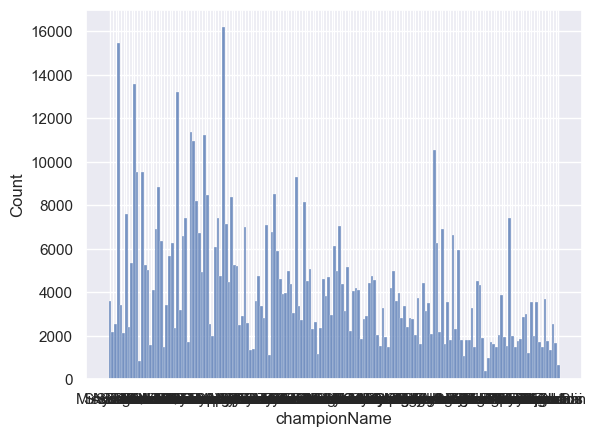

In [7]:
sns.histplot(cat_df, x = 'championName')

Severe class imbalance.

Roles:

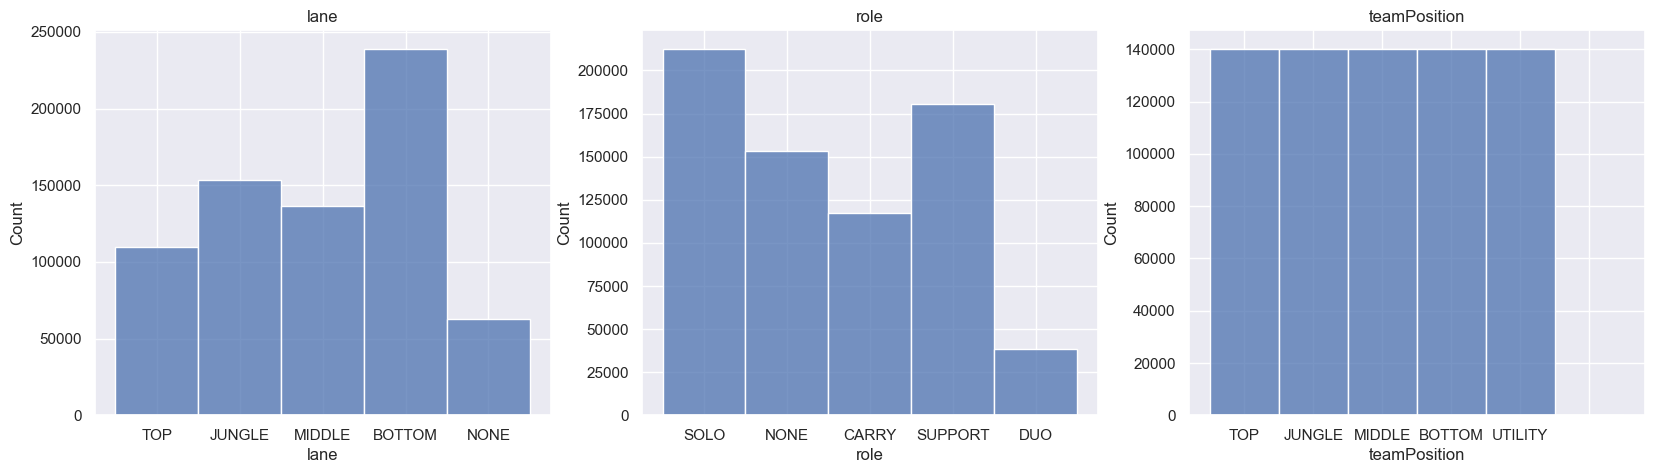

In [18]:
roles = ['lane', 'role', 'teamPosition']
fig, axs = plt.subplots(1, len(roles), figsize=(20, 5))
for i, feature in enumerate(roles):
    sns.histplot(data = cat_df, x = feature, ax = axs[i])
    axs[i].set_title(feature)

So these features seem to be somewhat the same, with lane and role seeming to be applied after the game is finished and teamPosition being noted at champion select>

So at this point, I would like to perform chi-squared tests of independence to determine which categorical features are associated with champion played. First I need to create contingency tables, then I perform chi-squared tests. 

In [19]:
from scipy.stats import chi2_contingency
def chi_squared_test(df, co1, co2, p_threshold):
    # Contingency table
    contingency_table = pd.crosstab(df[co1], df[co2])

    # Chi-squared test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Rejection region
    significant =  p < p_threshold
    return co1, chi2, significant


In [20]:
for feature in cat_df.columns:
    print(chi_squared_test(cat_df, feature, 'championName', 0.01))

('uuid', 119451939.99999957, False)
('matchId', 11297563.000000006, False)
('gameVersion', 17043.016761546216, True)
('summonerName', 72941356.56189156, True)
('puuid', 73693894.87583187, True)
('lane', 993767.1791277213, True)
('role', 1013627.2107123015, True)
('teamPosition', 1922063.6680689747, True)
('championName', 119451940.0, True)
('firstBloodAssist', 14627.579689451366, True)
('firstBloodKill', 11505.85088635546, True)
('firstTowerAssist', 11714.229211940024, True)
('firstTowerKill', 32718.712490390964, True)
('gameEndedInEarlySurrender', 231.3952667304911, True)
('gameEndedInSurrender', 486.83145765688454, True)
('teamEarlySurrendered', 205.72464958313762, False)
('win', 991.1714785980774, True)


gameVersion, summonerName, puuid, lane, role, teamPosition, championName, firtBloodAssist, firstBloodKill, firstTowerAssist, firstTowerKill, gameEndedInSurrender, win all seem to be related to champion picked. I'd like to see the impact that game version has on champion picked. The features with the highest chi-squared test values are puuid/summonerName, teamPosition/lane/role,gameVersin, firstbloodassist/kill, firsttowerassist/kill, win. One problem we have is that summonerName/puuid are more so ids than anything, of course people tend to play the same champions, but the name itself is not a predictor in anything.

Quantitative Features

In [6]:
num_df = df.select_dtypes(include = ['int', 'float'])
df.select_dtypes(include = ['int', 'float']).columns

Index(['totalHealsOnTeammates', 'largestCriticalStrike', 'damageSelfMitigated',
       'bountyLevel', 'consumablesPurchased', 'spell1Casts', 'spell2Casts',
       'spell3Casts', 'spell4Casts', 'summoner1Casts', 'summoner1Id',
       'summoner2Casts', 'summoner2Id', 'teamId', 'gameDuration',
       'summonerLevel', 'champExperience', 'champLevel', 'kills', 'deaths',
       'assists', 'doubleKills', 'tripleKills', 'quadraKills', 'pentaKills',
       'largestKillingSpree', 'largestMultiKill', 'killingSprees',
       'unrealKills', 'totalDamageDealt', 'totalDamageDealtToChampions',
       'totalDamageShieldedOnTeammates', 'totalDamageTaken', 'totalHeal',
       'trueDamageDealt', 'trueDamageDealtToChampions', 'trueDamageTaken',
       'magicDamageDealt', 'magicDamageDealtToChampions', 'magicDamageTaken',
       'physicalDamageDealt', 'physicalDamageDealtToChampions',
       'physicalDamageTaken', 'baronKills', 'damageDealtToBuildings',
       'damageDealtToObjectives', 'damageDealtToTurret

In [25]:
num_df.describe()

,totalHealsOnTeammates,largestCriticalStrike,damageSelfMitigated,bountyLevel,consumablesPurchased,spell1Casts,spell2Casts,spell3Casts,spell4Casts,summoner1Casts,...,visionScore,visionWardsBoughtInGame,wardsKilled,wardsPlaced,sightWardsBoughtInGame,longestTimeSpentLiving,timeCCingOthers,timePlayed,totalTimeCCDealt,totalTimeSpentDead
count,701540.000000,701540.000000,701540.000000,701540.000000,701540.000000,701540.000000,701540.000000,701540.000000,701540.000000,701540.000000,...,701540.000000,701540.000000,701540.000000,701540.000000,701540.0,701540.000000,701540.000000,701540.000000,701540.000000,701540.000000
mean,471.975913,220.783694,21868.905093,0.989764,3.163165,106.142792,55.776552,54.784987,14.890160,5.435545,...,25.937543,1.253658,2.460497,11.150780,0.0,605.146351,26.339400,1804.520441,295.353718,180.021004
std,1930.678930,373.745280,20218.136621,2.031036,2.621999,82.516841,44.300127,46.053609,25.636743,4.018572,...,20.847780,1.923515,2.943667,8.986207,0.0,294.224299,25.208103,444.855785,349.638633,120.834641
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,222.000000,0.000000,0.000000
25%,0.000000,0.000000,8896.000000,0.000000,1.000000,54.000000,25.000000,25.000000,6.000000,3.000000,...,13.000000,0.000000,0.000000,6.000000,0.0,408.000000,10.000000,1543.000000,108.000000,88.000000
50%,0.000000,0.000000,15492.000000,0.000000,2.000000,84.000000,44.000000,44.000000,9.000000,4.000000,...,20.000000,0.000000,2.000000,9.000000,0.0,557.000000,21.000000,1805.000000,208.000000,164.000000
75%,0.000000,387.000000,28021.000000,1.000000,4.000000,132.000000,75.000000,72.000000,14.000000,6.000000,...,31.000000,2.000000,3.000000,13.000000,0.0,753.000000,35.000000,2077.000000,361.000000,251.000000
max,81183.000000,8917.000000,392246.000000,38.000000,49.000000,1225.000000,967.000000,1308.000000,984.000000,41.000000,...,239.000000,48.000000,54.000000,294.000000,0.0,3163.000000,525.000000,4108.000000,18500.000000,1175.000000


<Axes: xlabel='gameDuration', ylabel='Count'>

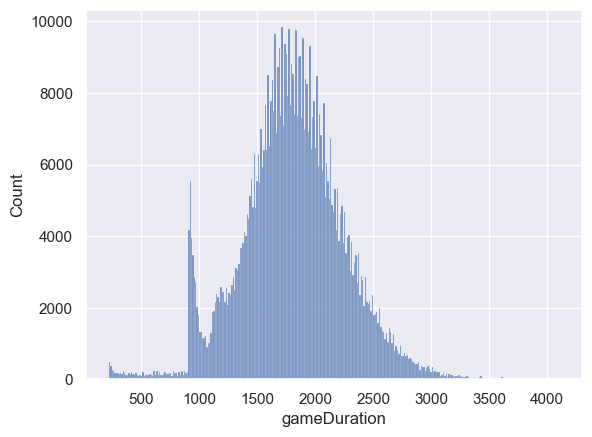

In [39]:
sns.histplot(num_df, x='gameDuration')

In [16]:
num_df['gameDuration'].describe()

count    701540.000000
mean       1804.520441
std         444.855785
min         222.000000
25%        1543.000000
50%        1805.000000
75%        2077.000000
max        4108.000000
Name: gameDuration, dtype: float64

In [10]:
timecorrs = num_df.corr()['gameDuration']
timecorrs.sort_values(ascending=False).head(20)

gameDuration                   1.000000
timePlayed                     1.000000
champLevel                     0.878330
champExperience                0.874843
goldEarned                     0.818581
goldSpent                      0.817290
itemsPurchased                 0.763851
totalDamageTaken               0.724283
totalTimeSpentDead             0.688748
totalDamageDealtToChampions    0.669352
magicDamageTaken               0.649656
totalDamageDealt               0.609485
physicalDamageTaken            0.600405
deaths                         0.568691
assists                        0.518982
damageSelfMitigated            0.515541
turretsLost                    0.495398
item4                          0.455315
trueDamageTaken                0.428525
visionScore                    0.427365
Name: gameDuration, dtype: float64

So timePlayed and gameDuration are the exact same feature. Features that are very linear with time in game like level, gold earned, damage given and taken are all highly correlated with time. Interesting to see though that physical and magic damage dealt are not correlated with time as some champions cannot do physical/magic damage. Deaths and assists seem to be correlated with time, but what about kills? How come kills are not correlated with time as much as deaths or assists?

In [5]:
corr = num_df.corr()

<Axes: >

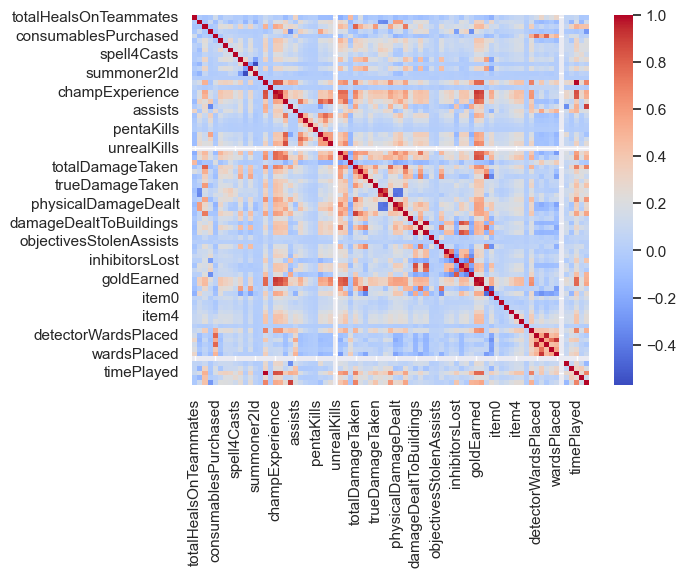

In [17]:
sns.heatmap(corr, cmap='coolwarm')

there seems to be many areas of medium-high correlation

In [6]:
# Set a threshold for high correlation
threshold = 0.6

# Find pairs of features with high correlation
high_corr_pairs = (
    corr
    .unstack()
    .reset_index()
    .rename(columns={0: 'correlation', 'level_0': 'Feature1', 'level_1': 'Feature2'})
)

# Filter out self-correlations and duplicates
high_corr_pairs = high_corr_pairs[
    (high_corr_pairs['Feature1'] != high_corr_pairs['Feature2']) &
    (abs(high_corr_pairs['correlation']) > threshold)
]

In [7]:
high_corr_pairs

,Feature1,Feature2,correlation
190,damageSelfMitigated,totalDamageTaken,0.791997
194,damageSelfMitigated,trueDamageTaken,0.603600
200,damageSelfMitigated,physicalDamageTaken,0.722363
384,consumablesPurchased,detectorWardsPlaced,0.780708
386,consumablesPurchased,visionWardsBoughtInGame,0.783151
...,...,...,...
6176,totalTimeSpentDead,gameDuration,0.683797
6181,totalTimeSpentDead,deaths,0.892586
6194,totalTimeSpentDead,totalDamageTaken,0.690266
6201,totalTimeSpentDead,magicDamageTaken,0.611285


# K-means clustering

first i need to reduce dimensions of dataset, how can i do this?

Feature transformations

In [9]:
# Dividing features that are highly correlated with time so they are "per second"
high_time_corr = ["champLevel", "champExperience",
                   "goldEarned", "goldSpent",
                     "itemsPurchased", "totalDamageTaken",
                       "totalTimeSpentDead", "totalDamageDealtToChampions",
                         "magicDamageTaken", "totalDamageDealt",
                           "physicalDamageTaken", "deaths",
                             "assists", "damageSelfMitigated"
]


for feature in high_time_corr:
    df[feature] = df[feature] / df['gameDuration']

There seems to be an unusually high number of correlated pairs of features... It'd be interesting to see the correlation between gametime and different features. There seems to be a whole lot of multicollinearity

In [10]:
from sklearn.model_selection import train_test_split

# Prepare predictors dataframe
X = df.drop(['uuid', 'matchId', 'gameVersion', 'summonerName', 'puuid', 'lane',
       'role', 'championName', 'firstBloodAssist',
       'firstBloodKill', 'firstTowerAssist', 'firstTowerKill',
       'gameEndedInEarlySurrender', 'gameEndedInSurrender',
       'teamEarlySurrendered'], axis = 1)

# Target dataframe
y = df['championName']


# One hot encode 
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
onehot = OneHotEncoder(sparse_output=False)
categorical_cols = ['teamPosition', 'win']

# Fit and transform the data
encoded_array = onehot.fit_transform(X[categorical_cols])

# Create a new dataframe with encoded features
encoded_df = pd.DataFrame(encoded_array, columns=onehot.get_feature_names_out(categorical_cols))

# Combine with original numeric features
final_df = pd.concat([X.drop(columns=categorical_cols), encoded_df], axis=1)

X_train, X_test, y_train, y_test = train_test_split(final_df, y, test_size = 0.3)


In [6]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_jobs=4, class_weight='balanced')

clf.fit(X_train, y_train)
preds = clf.predict(X_test)

In [7]:
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score, classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay 

print(balanced_accuracy_score(preds, y_test))
class_report = classification_report(preds, y_test)
print(class_report)

0.9489468678163372
              precision    recall  f1-score   support

      Aatrox       0.97      0.94      0.96      2024
        Ahri       0.97      0.97      0.97      1168
       Akali       0.99      0.95      0.97      2281
      Akshan       0.87      0.89      0.88       803
     Alistar       0.92      0.97      0.95       580
       Amumu       0.89      0.96      0.92      1075
      Anivia       0.96      0.98      0.97       643
       Annie       0.86      0.94      0.90       565
    Aphelios       0.99      0.98      0.98       796
        Ashe       0.99      0.99      0.99      2855
 AurelionSol       0.96      0.92      0.94      1428
        Azir       0.96      0.99      0.97       778
        Bard       0.92      0.94      0.93      1042
     Belveth       0.95      0.93      0.94      1095
  Blitzcrank       0.88      0.84      0.86      1458
       Brand       0.93      0.87      0.90      3688
       Braum       0.73      0.93      0.82       372
       B

In [8]:
importances = clf.feature_importances_
feature_names = X_train.columns

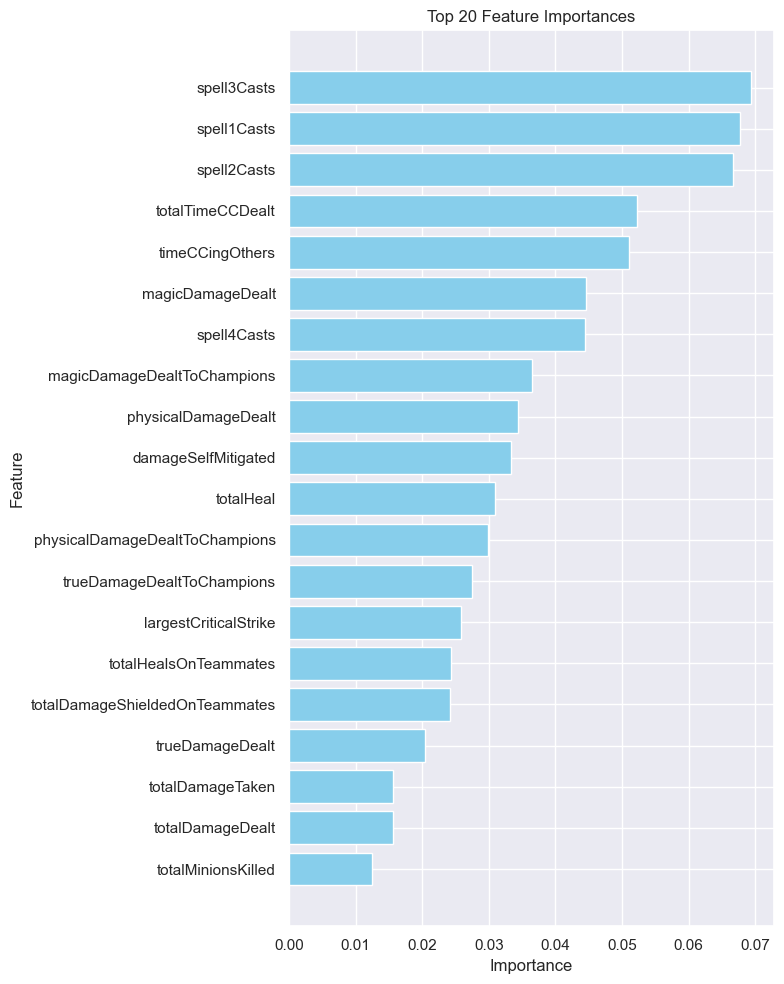

In [9]:
# Sort features by importance
indices = np.argsort(importances)[::-1]
top_n = 20  # Specify the number of top features to display
top_indices = indices[:top_n]

# Plot
plt.figure(figsize=(8, 10))  # Adjust figure size for vertical orientation
plt.title("Top 20 Feature Importances")
plt.barh(range(len(top_indices)), importances[top_indices], align="center", color="skyblue")
plt.yticks(range(len(top_indices)), [feature_names[i] for i in top_indices])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.tight_layout()
plt.show()

In [10]:
X2 = df[[feature_names[i] for i in top_indices]]

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size=0.3)

In [ ]:
from sklearn.cluster import KMeans

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [11]:
clf2 = RandomForestClassifier(n_jobs=2, class_weight='balanced', random_state=42)

In [12]:
clf2.fit(X_train2, y_train2)

RandomForestClassifier(class_weight='balanced', n_jobs=2, random_state=42)

In [14]:
preds2 = clf2.predict(X_test2)
print(classification_report(preds2, y_test2))

              precision    recall  f1-score   support

      Aatrox       0.97      0.96      0.96      1976
        Ahri       0.97      0.97      0.97      1161
       Akali       0.98      0.97      0.97      2193
      Akshan       0.91      0.95      0.93       737
     Alistar       0.95      0.95      0.95       620
       Amumu       0.93      0.97      0.95      1044
      Anivia       0.96      0.98      0.97       633
       Annie       0.89      0.35      0.50      1511
    Aphelios       0.98      0.96      0.97       818
        Ashe       0.99      1.00      0.99      2830
 AurelionSol       0.96      0.93      0.94      1366
        Azir       0.97      0.98      0.97       765
        Bard       0.93      0.94      0.93      1022
     Belveth       0.95      0.96      0.95      1104
  Blitzcrank       0.90      0.87      0.88      1478
       Brand       0.95      0.91      0.93      3499
       Braum       0.77      0.93      0.84       410
       Briar       0.99    